In [112]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
# Load multiple JSON files into a single DataFrame
dfs = []
for file_name in ['./scrap/uk_indeed_v1.json', './scrap/uk_indeed_v2.json', './scrap/uk_indeed_v3.json', 
                  './scrap/uk_indeed_v4.json', './scrap/uk_indeed_v5.json']:
    with open(file_name) as file:
        data = json.load(file)
        dfs.append(pd.DataFrame(data))

# Concatenate the DataFrames
df = pd.concat(dfs, ignore_index=True)

# Remove duplicates based on 'jobkey'
df.drop_duplicates(subset='jobkey', inplace=True)

# Normalize all entries across all columns
df = df.applymap(lambda x: str(x).lower() if isinstance(x, str) else x)

# Top 11 biggest cities in the UK (lowercased to fit previous operations)
location_list = ['london', 'birmingham', 'manchester', 'glasgow', 'leeds', 'sheffield', 'bradford', 'edinburgh', 'liverpool', 'bristol', 'cardiff']

In [114]:
# Check unique postings
print(f"Length of the DataFrame: {len(df)}")

Length of the DataFrame: 14244


In [115]:
# Function to extract skills from jobCardRequirementsModel
def extract_skills(row):
    skills = []
    for req in row['jobCardRequirementsModel']['jobOnlyRequirements']:
        label = req.get('label')
        if label is not None:
            skills.append(label.lower())
    return skills
# Extract skills and job positions
df['skills'] = df.apply(extract_skills, axis=1)
df['job_position'] = df['jobTitle']

In [116]:
# Function to calculate median salary based on min/max from posting
def calculate_median_salary(salary_info):
    if pd.isna(salary_info):
        return np.nan
    else:
        return (salary_info['min'] + salary_info['max']) / 2


df['median_salary'] = df['extractedSalary'].apply(calculate_median_salary)
df['num_required_skills'] = df['jobCardRequirementsModel'].apply(lambda x: len([req for req in x['jobOnlyRequirements'] if req['strictness'] == 'required']))

In [117]:
# Function to extract benefits
def extract_benefits(taxonomy_attributes):
    benefits = []
    for attribute in taxonomy_attributes:
        if attribute['label'] == 'benefits':
            benefits.extend([attr['label'] for attr in attribute['attributes']])
    return benefits


In [118]:
# Function to extract hires needed if applicable
def extract_hires_needed(hiring_model):
    if hiring_model is None or 'hiresNeeded' not in hiring_model:
        return 'Unknown'
    else:
        return hiring_model['hiresNeeded']

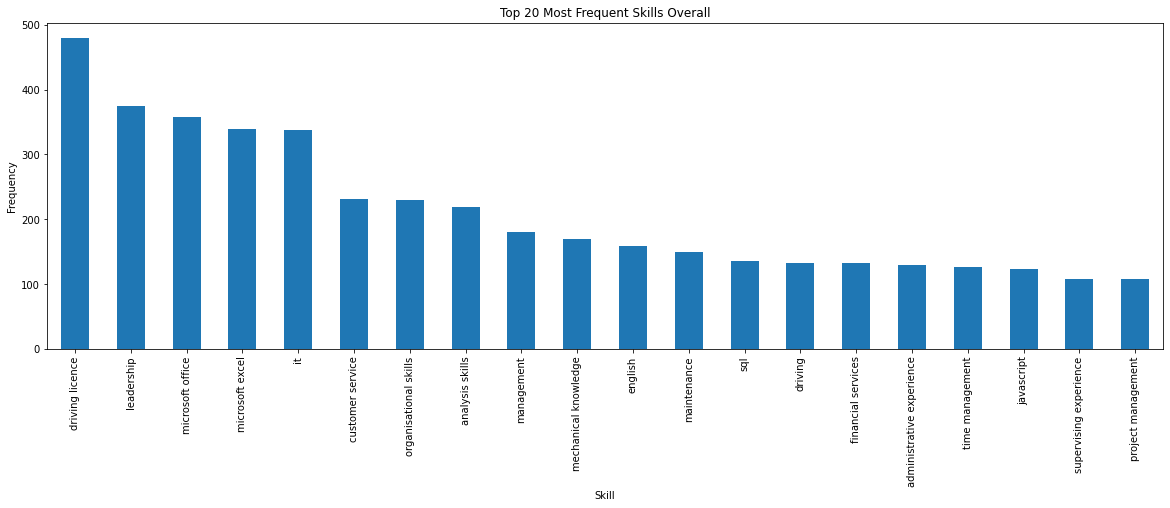

In [141]:
# Top N most frequent skills overall
top_skills_overall = df.explode('skills')['skills'].value_counts().head(20)
plt.figure(figsize=(20, 6))
top_skills_overall.plot(kind='bar')
plt.title('Top 20 Most Frequent Skills Overall')
plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.show()

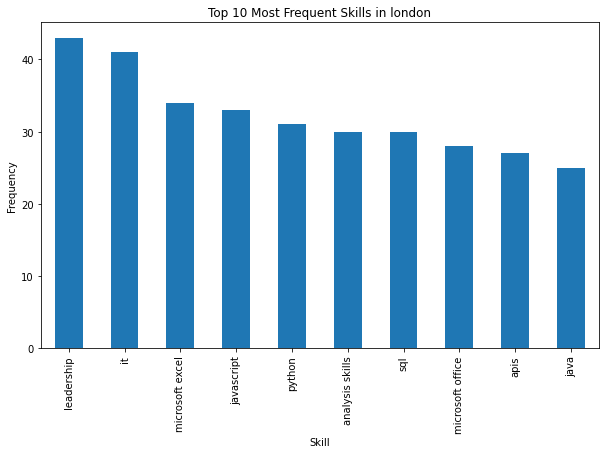

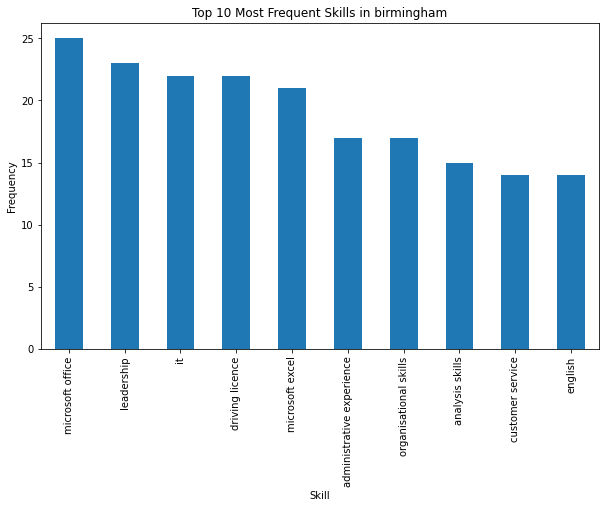

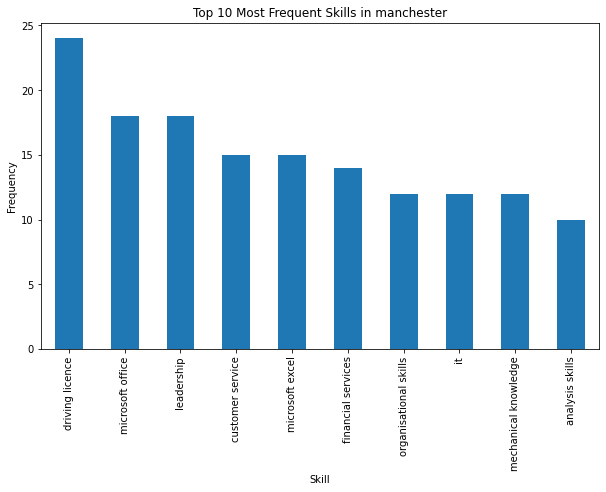

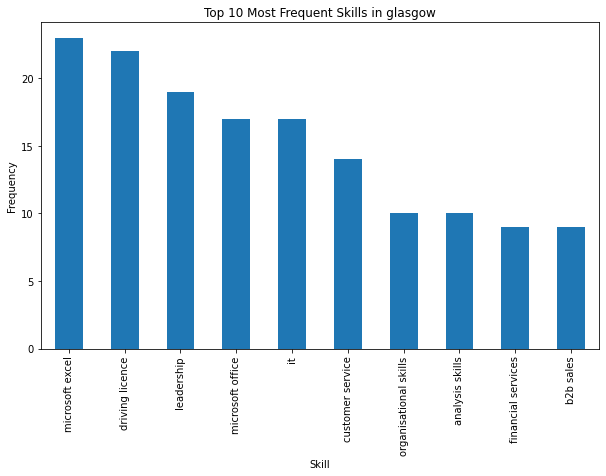

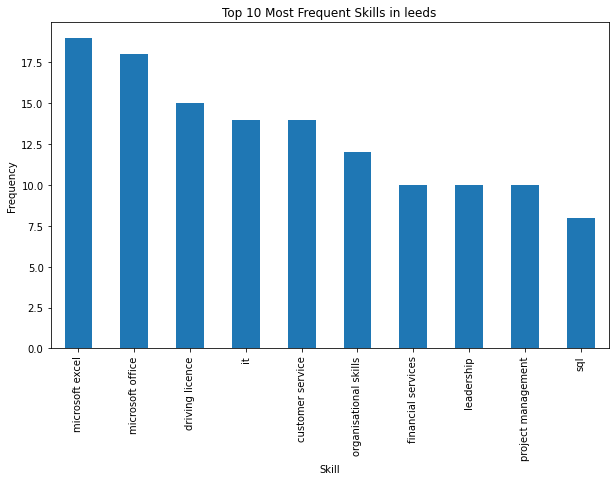

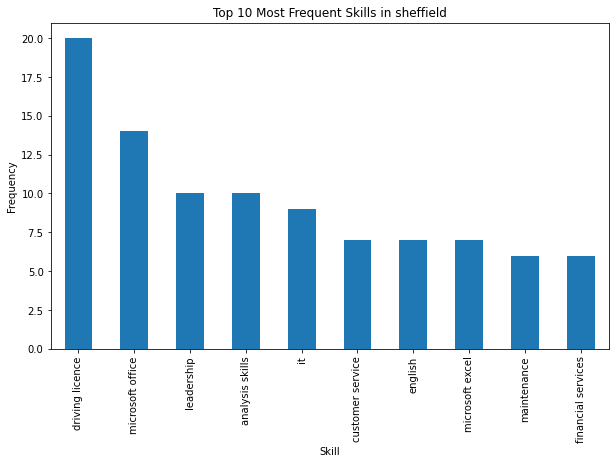

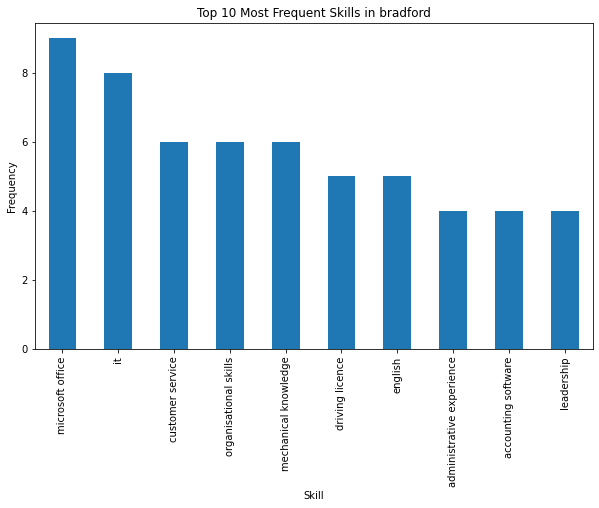

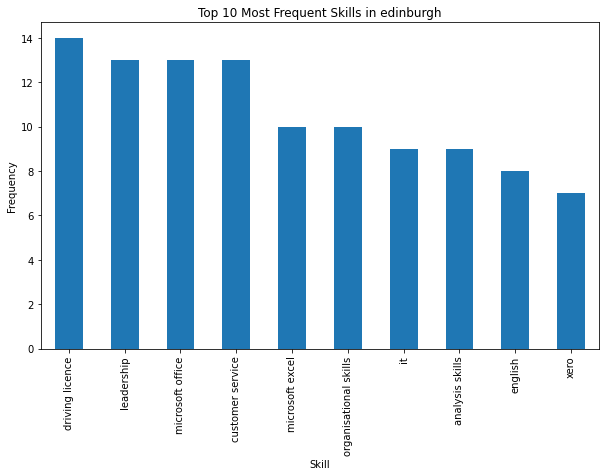

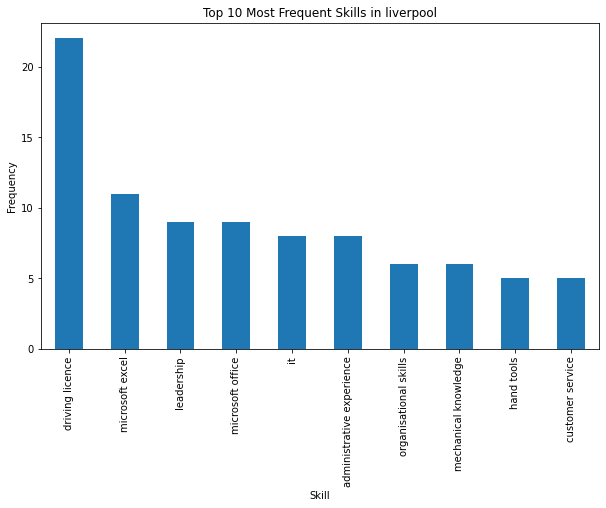

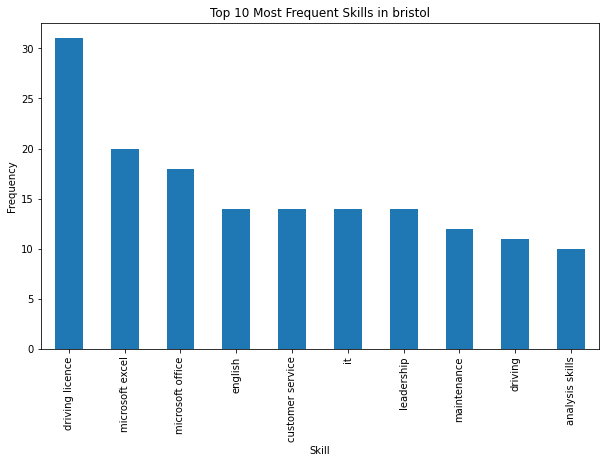

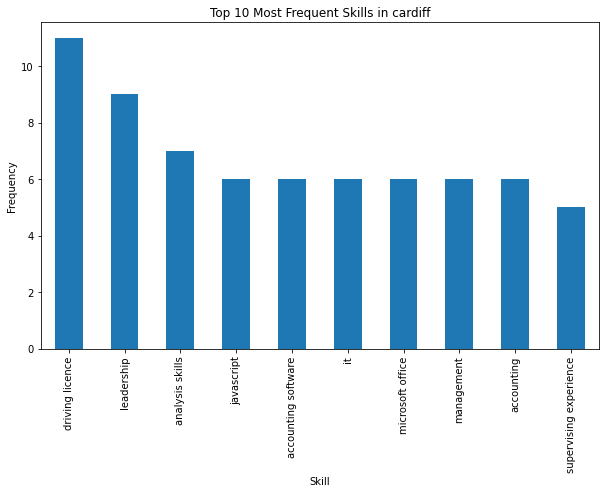

In [120]:
# Top N most frequent skills per city
for city in location_list:
    if city in df['jobLocationCity'].unique():
        city_skills = df[df['jobLocationCity'] == city].explode('skills')['skills'].value_counts().head(10)
        plt.figure(figsize=(10, 6))
        city_skills.plot(kind='bar')
        plt.title(f'Top 10 Most Frequent Skills in {city}')
        plt.xlabel('Skill')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"No data available for {city}")

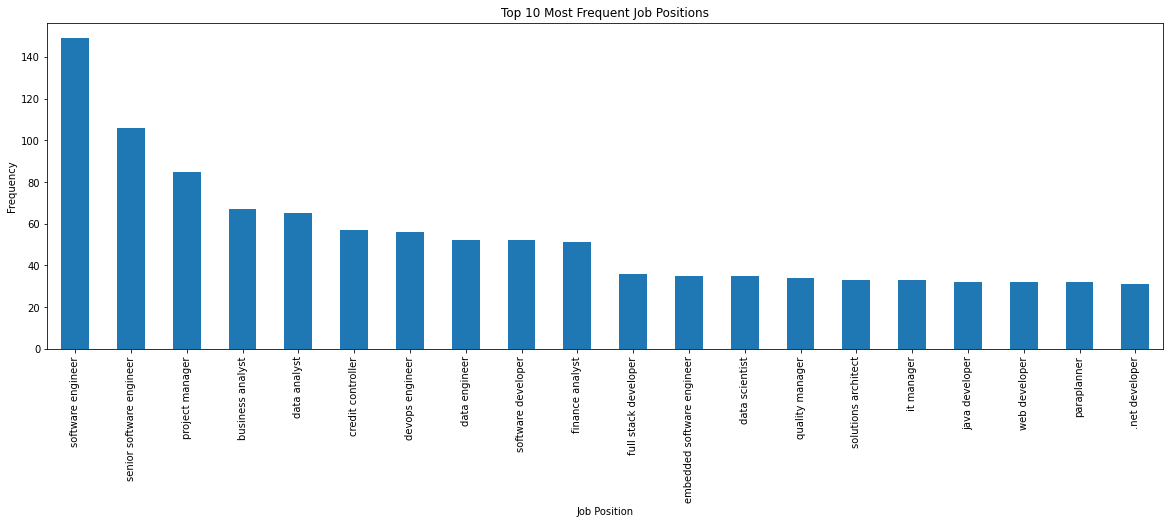

In [143]:
# Top N most frequent job positions
top_job_positions = df['job_position'].value_counts().head(20)
plt.figure(figsize=(20, 6))
top_job_positions.plot(kind='bar')
plt.title('Top 10 Most Frequent Job Positions')
plt.xlabel('Job Position')
plt.ylabel('Frequency')
plt.show()

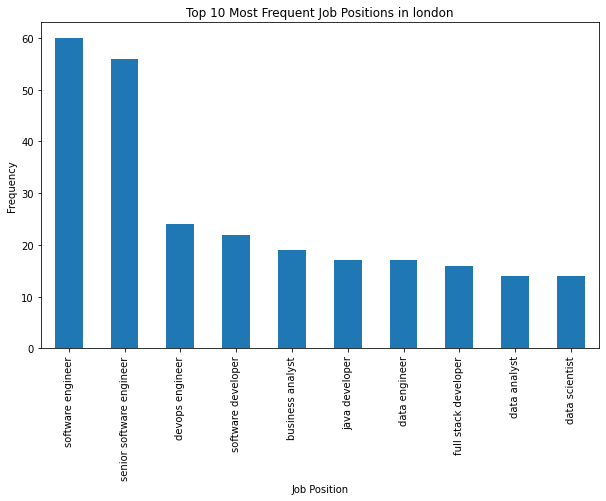

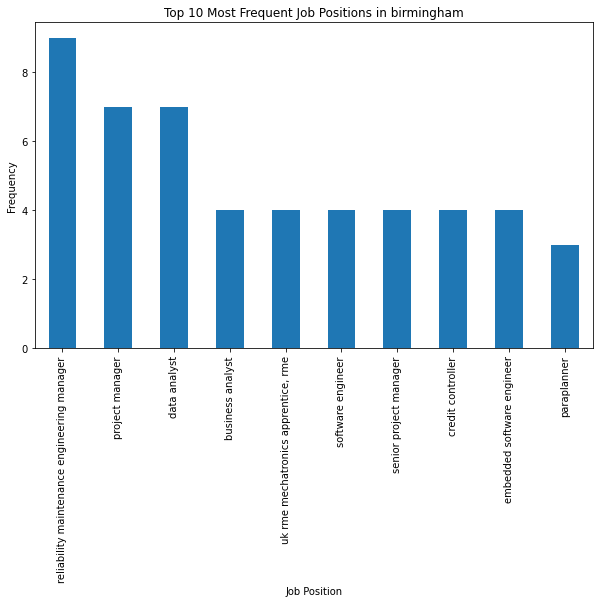

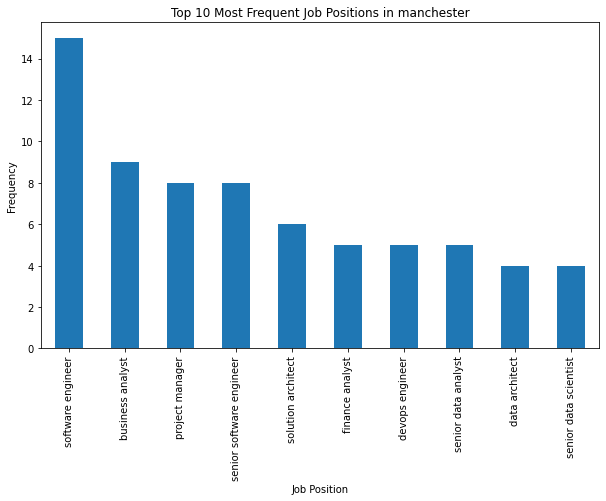

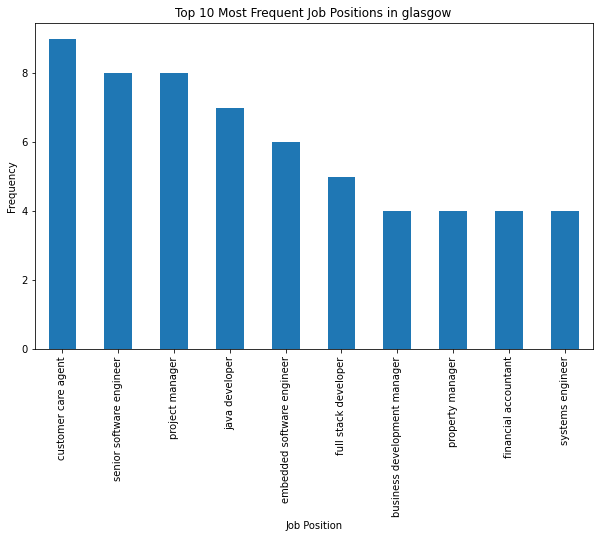

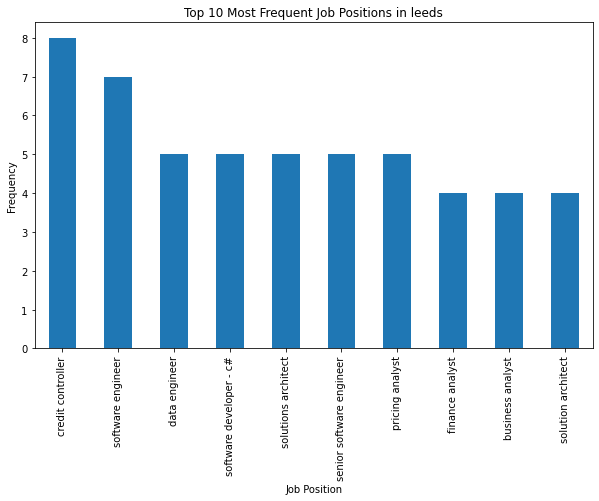

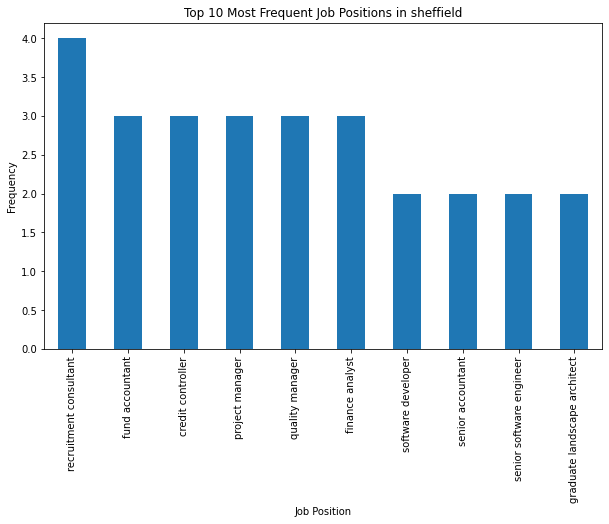

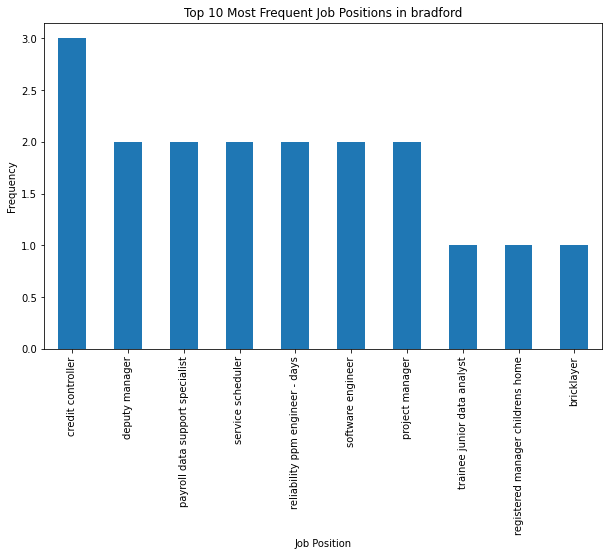

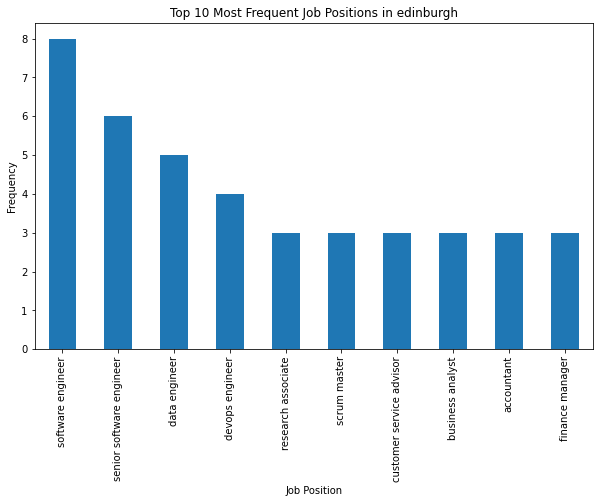

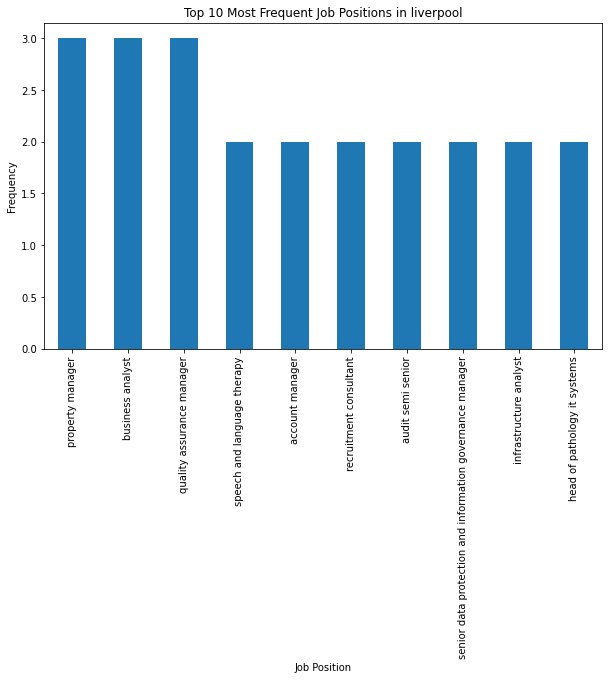

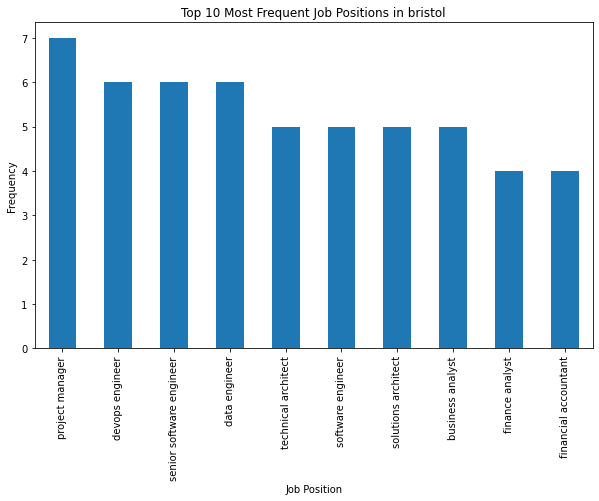

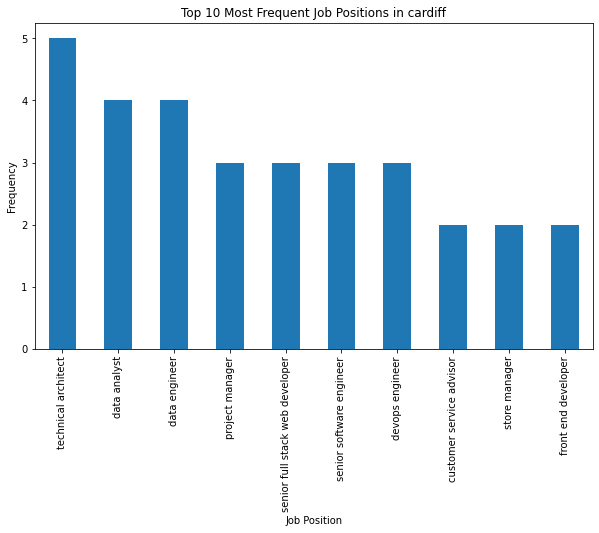

In [122]:
# Top 10 most frequent job positions per city (filtered for top 10 biggest cities)
for city in location_list:
    if city in df['jobLocationCity'].unique():
        city_job_positions = df[df['jobLocationCity'] == city]['job_position'].value_counts().head(10)
        plt.figure(figsize=(10, 6))
        city_job_positions.plot(kind='bar')
        plt.title(f'Top 10 Most Frequent Job Positions in {city}')
        plt.xlabel('Job Position')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"No data available for {city}")

/Users/radoslawizak/Desktop/MSc Data Science/Semester 2/DATA70202/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


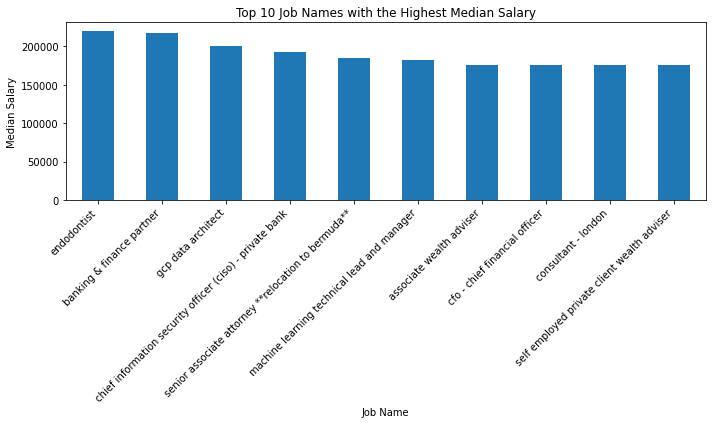

In [123]:
# Top N job names with the highest median salary
salary_data = df[df['extractedSalary'].notna()]
salary_data['median_salary'] = salary_data['extractedSalary'].apply(calculate_median_salary)
top_jobs_salary = salary_data.groupby('jobTitle')['median_salary'].median().nlargest(10)
plt.figure(figsize=(10, 6))
top_jobs_salary.plot(kind='bar')
plt.title('Top 10 Job Names with the Highest Median Salary')
plt.xlabel('Job Name')
plt.ylabel('Median Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

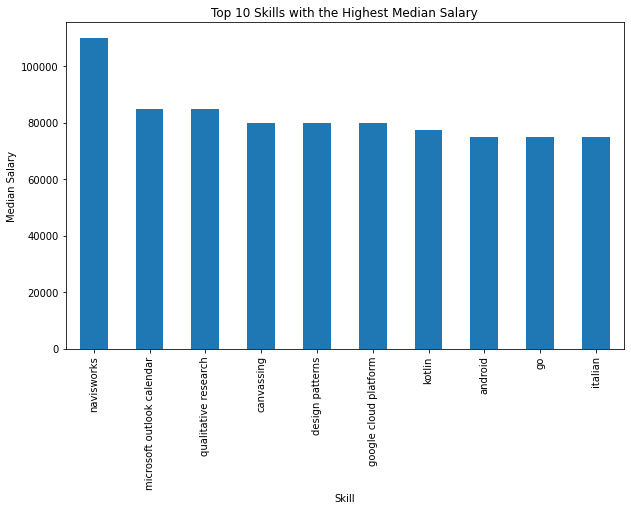

In [124]:
# Top N skills with the highest median salary
skill_salary_data = salary_data.explode('skills')[['skills', 'median_salary']]
top_skills_salary = skill_salary_data.groupby('skills')['median_salary'].median().nlargest(10)
plt.figure(figsize=(10, 6))
top_skills_salary.plot(kind='bar')
plt.title('Top 10 Skills with the Highest Median Salary')
plt.xlabel('Skill')
plt.ylabel('Median Salary')
plt.show()

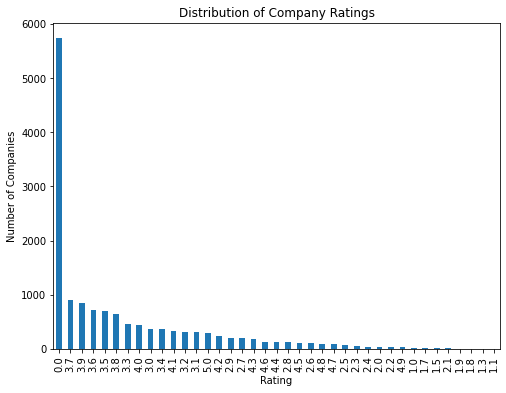

In [125]:
# Distribution of company ratings
company_ratings = df['companyRating'].value_counts()
plt.figure(figsize=(8, 6))
company_ratings.plot(kind='bar')
plt.title('Distribution of Company Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Companies')
plt.show()

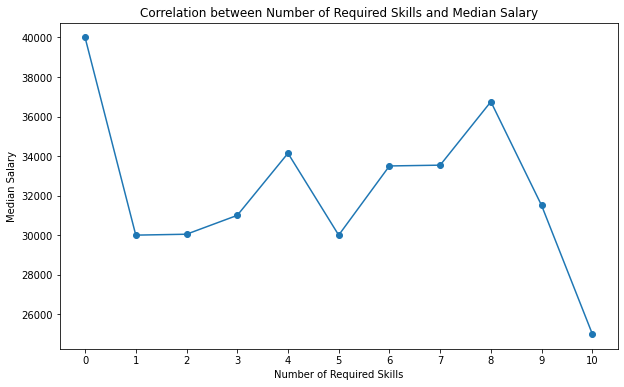

In [126]:
# Correlation between number of required skills and median salary
skill_salary_corr = df.groupby('num_required_skills')['median_salary'].median()
plt.figure(figsize=(10, 6))
skill_salary_corr.plot(kind='line', marker='o')
plt.title('Correlation between Number of Required Skills and Median Salary')
plt.xlabel('Number of Required Skills')
plt.ylabel('Median Salary')
plt.xticks(range(min(skill_salary_corr.index), max(skill_salary_corr.index) + 1))
plt.show()

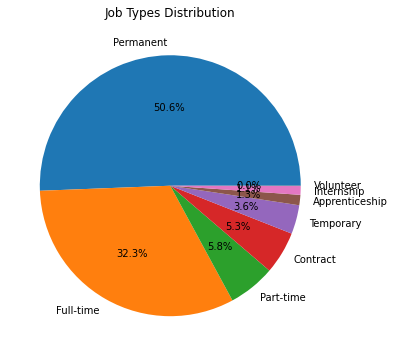

In [127]:
# Job types distribution
job_types = df.explode('jobTypes')['jobTypes'].value_counts()
plt.figure(figsize=(8, 6))
job_types.plot(kind='pie', autopct='%1.1f%%')
plt.title('Job Types Distribution')
plt.ylabel('')
plt.show()

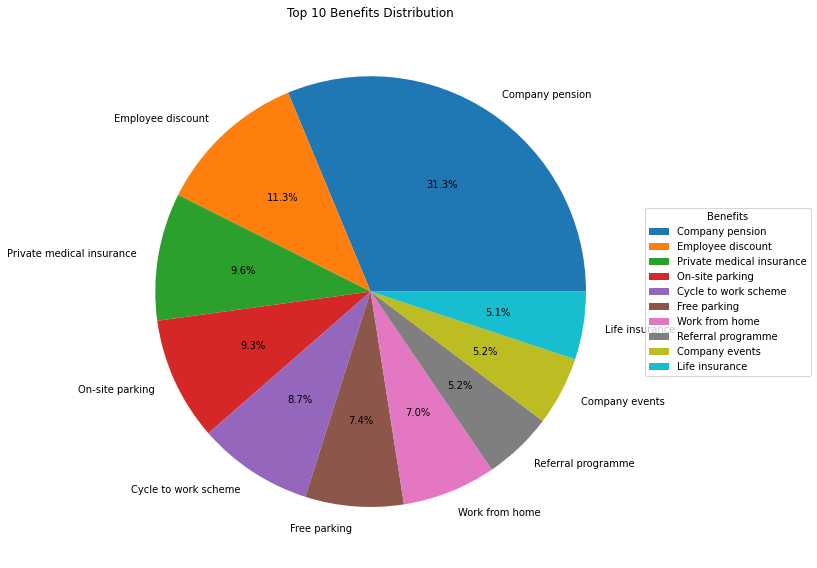

In [128]:
# Top 10 benefits distribution
benefits_data = df['taxonomyAttributes'].apply(extract_benefits).explode().value_counts().nlargest(10)
plt.figure(figsize=(10, 8))
benefits_data.plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 Benefits Distribution')
plt.ylabel('')
plt.legend(title='Benefits', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

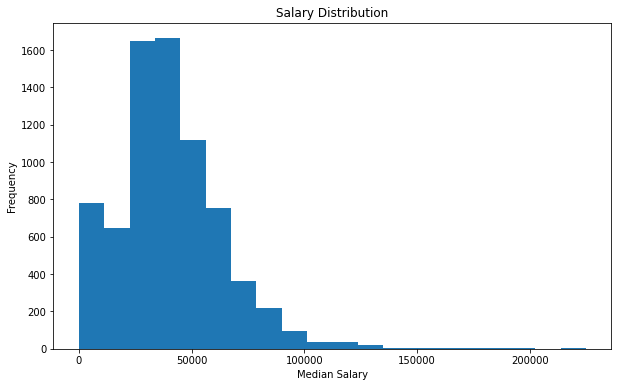

In [129]:
# Salary distribution
plt.figure(figsize=(10, 6))
plt.hist(salary_data['median_salary'], bins=20)
plt.title('Salary Distribution')
plt.xlabel('Median Salary')
plt.ylabel('Frequency')
plt.show()


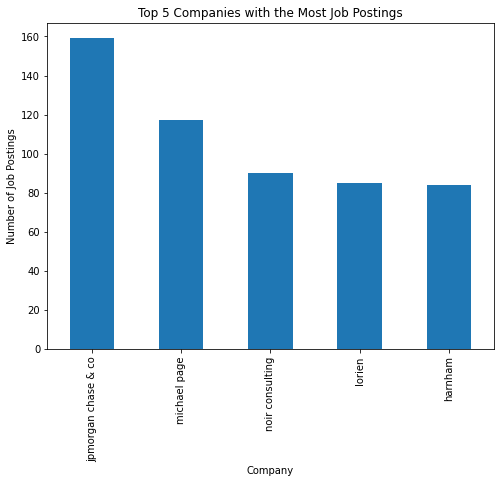

In [130]:
# Top N companies with the most job postings
top_companies = df['company'].value_counts().head(5)
plt.figure(figsize=(8, 6))
top_companies.plot(kind='bar')
plt.title('Top 5 Companies with the Most Job Postings')
plt.xlabel('Company')
plt.ylabel('Number of Job Postings')
plt.show()

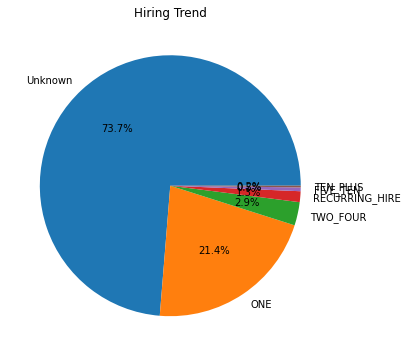

In [131]:
# Hiring trend (single vs multiple candidates)
hiring_trend = df['hiringMultipleCandidatesModel'].apply(extract_hires_needed).value_counts()
plt.figure(figsize=(8, 6))
hiring_trend.plot(kind='pie', autopct='%1.1f%%')
plt.title('Hiring Trend')
plt.ylabel('')
plt.show()


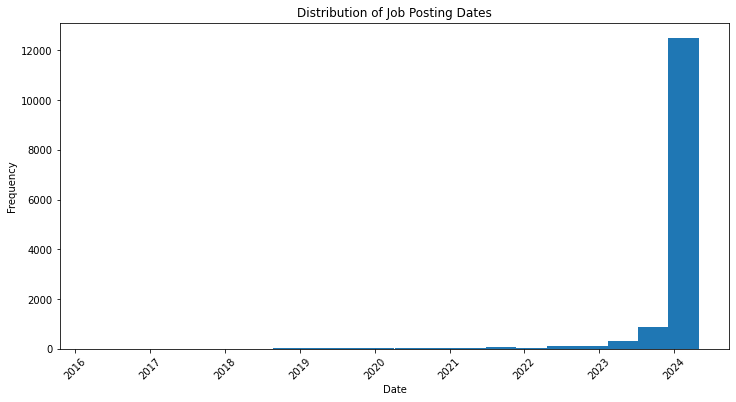

In [132]:
# Distribution of Job Posting Dates
df['pubDate'] = pd.to_datetime(df['pubDate'], unit='ms')
plt.figure(figsize=(12, 6))
plt.hist(df['pubDate'], bins=20)
plt.title('Distribution of Job Posting Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

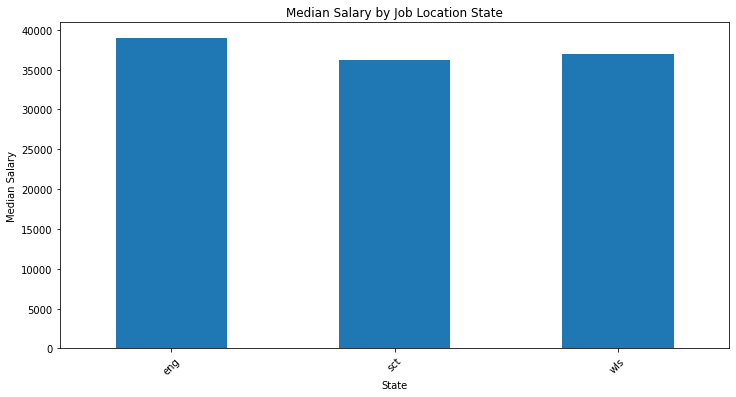

In [133]:
# Median Salary by Job Location State
state_median_salary = df.groupby('jobLocationState')['median_salary'].median()
plt.figure(figsize=(12, 6))
state_median_salary.plot(kind='bar')
plt.title('Median Salary by Job Location State')
plt.xlabel('State')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.show()

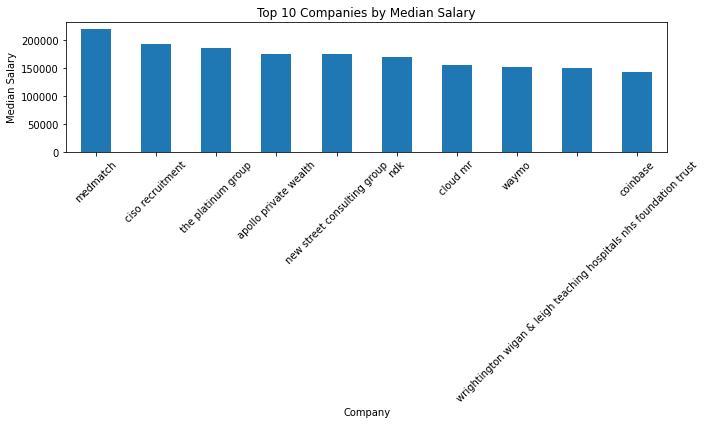

In [134]:
# Top N Companies by Median Salary
top_companies_salary = df.groupby('company')['median_salary'].median().nlargest(10)
plt.figure(figsize=(10, 6))
top_companies_salary.plot(kind='bar')
plt.title('Top 10 Companies by Median Salary')
plt.xlabel('Company')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 864x576 with 0 Axes>

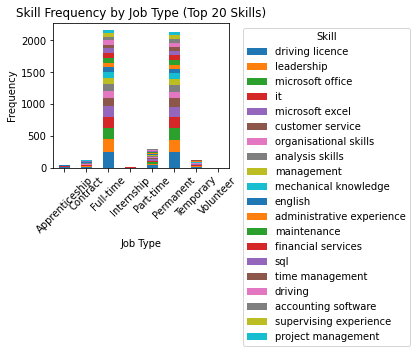

In [135]:
# Skill Frequency by Job Type (Top N Skills)
job_type_skills = df.explode('skills').explode('jobTypes').groupby(['jobTypes', 'skills']).size().unstack()
job_type_skills.fillna(0, inplace=True)

# Select top 20 skills based on overall frequency
top_20_skills = job_type_skills.sum().nlargest(20).index
job_type_skills_top_20 = job_type_skills[top_20_skills]

plt.figure(figsize=(12, 8))
job_type_skills_top_20.plot(kind='bar', stacked=True)
plt.title('Skill Frequency by Job Type (Top 20 Skills)')
plt.xlabel('Job Type')
plt.ylabel('Frequency')
plt.legend(title='Skill', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

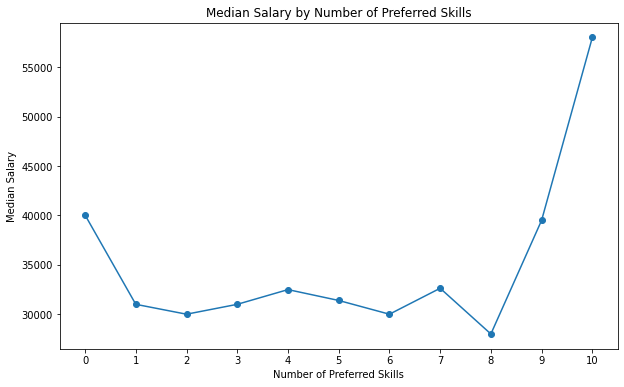

In [136]:
# Median Salary by Number of Preferred Skills
df['num_preferred_skills'] = df['jobCardRequirementsModel'].apply(lambda x: len([req for req in x['jobOnlyRequirements'] if req['strictness'] == 'preferred']))
preferred_skill_salary = df.groupby('num_preferred_skills')['median_salary'].median()
plt.figure(figsize=(10, 6))
preferred_skill_salary.plot(kind='line', marker='o')
plt.title('Median Salary by Number of Preferred Skills')
plt.xlabel('Number of Preferred Skills')
plt.ylabel('Median Salary')
plt.xticks(range(min(preferred_skill_salary.index), max(preferred_skill_salary.index) + 1))
plt.show()

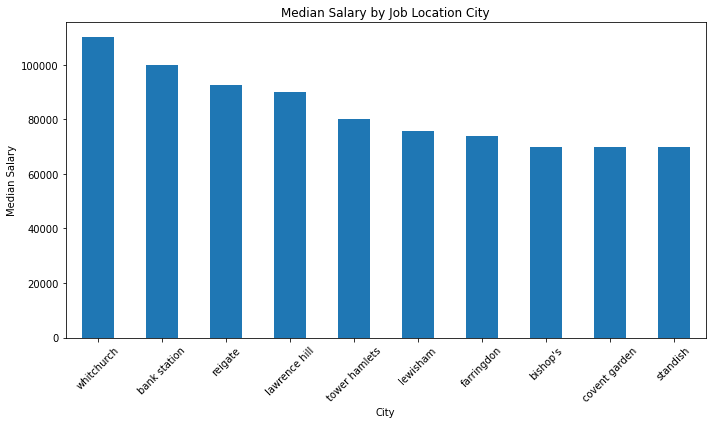

In [137]:
# Graph 15: Median Salary by Job Location City
city_median_salary = df.groupby('jobLocationCity')['median_salary'].median().nlargest(10)
plt.figure(figsize=(10, 6))
city_median_salary.plot(kind='bar')
plt.title('Median Salary by Job Location City')
plt.xlabel('City')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

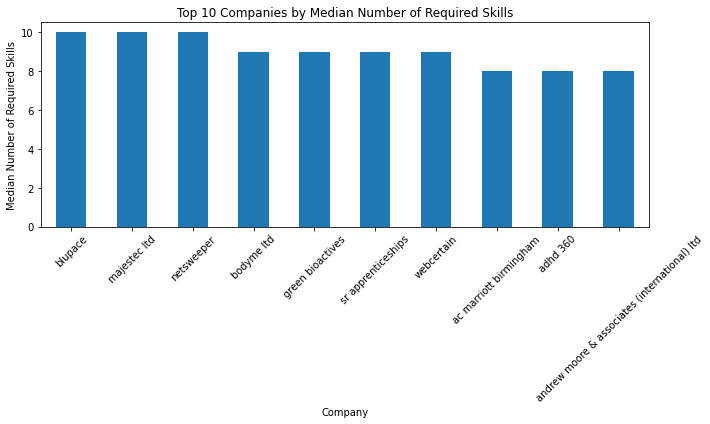

In [138]:
# Top N Companies by Median Number of Required Skills
top_companies_required_skills = df.groupby('company')['num_required_skills'].median().nlargest(10)
plt.figure(figsize=(10, 6))
top_companies_required_skills.plot(kind='bar')
plt.title('Top 10 Companies by Median Number of Required Skills')
plt.xlabel('Company')
plt.ylabel('Median Number of Required Skills')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

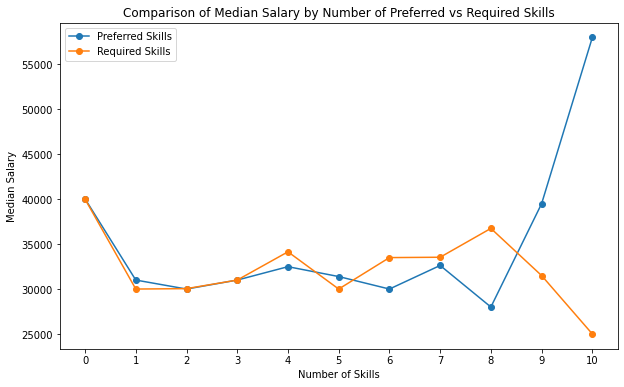

In [139]:
# Comparison of Median Salary by Number of Preferred vs Required Skills
plt.figure(figsize=(10, 6))
plt.plot(preferred_skill_salary, marker='o', label='Preferred Skills')
plt.plot(skill_salary_corr, marker='o', label='Required Skills')
plt.title('Comparison of Median Salary by Number of Preferred vs Required Skills')
plt.xlabel('Number of Skills')
plt.ylabel('Median Salary')
plt.legend()
plt.xticks(range(max(min(preferred_skill_salary.index), min(skill_salary_corr.index)),
                 max(max(preferred_skill_salary.index), max(skill_salary_corr.index)) + 1))
plt.show()

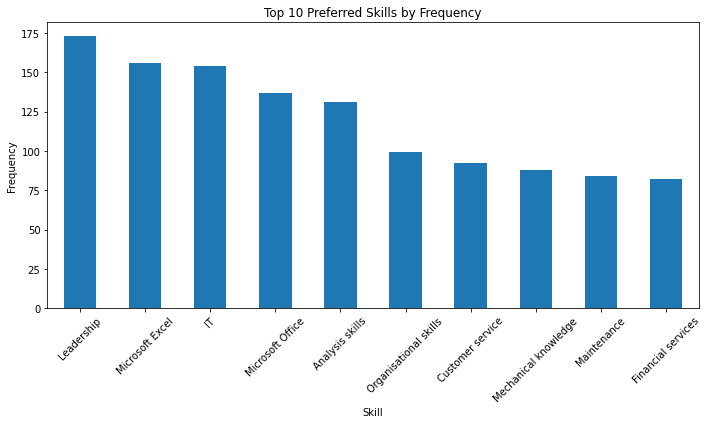

In [140]:
# Extract preferred skills
preferred_skills = df['jobCardRequirementsModel'].apply(lambda x: [req['label'] for req in x.get('jobOnlyRequirements', []) if req.get('strictness') == 'preferred'])
preferred_skills = preferred_skills.explode()

preferred_skills_freq = preferred_skills.value_counts()
top_10_preferred_skills = preferred_skills_freq.nlargest(10)

# Plot the top 10 preferred skills
plt.figure(figsize=(10, 6))
top_10_preferred_skills.plot(kind='bar')
plt.title('Top 10 Preferred Skills by Frequency')
plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()